In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import sys
from pathlib import Path
if IN_COLAB:
    !pip install open-clip-torch
    !pip install jaxtyping einops open-clip-torch ftfy regex timm

    !git clone https://github.com/niccobarto/token-opt-generator.git
    REPO_DIR = Path('/content/token-opt-generator')
    PERSONAL_PROJECT_DIR=Path('content/token-opt-generator/tester')
    TOKEN_OPT_DIR= REPO_DIR/"token-opt"
    sys.path.insert(0,str(TOKEN_OPT_DIR))
    sys.path.insert(0,str(REPO_DIR))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.8 MB/s eta 0:00:00
Cloning into 'token-opt-generator'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 173 (delta 39), reused 139 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 27.97 MiB | 22.79 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
if IN_COLAB:
  !unzip "/content/inputs.zip"


Archive:  /content/inputs.zip
   creating: inputs/
   creating: inputs/clean/
   creating: inputs/clean/chair/
  inflating: inputs/clean/chair/sedia1.jpg  
  inflating: inputs/clean/chair/sedia3.jpg  
   creating: inputs/clean/cup/
  inflating: inputs/clean/cup/tazza1.jpg  
  inflating: inputs/clean/cup/tazzaa2.jpg  
   creating: inputs/clean/lamp/
  inflating: inputs/clean/lamp/lampada1.jpg  
  inflating: inputs/clean/lamp/lampada2.jpg  
   creating: inputs/clean/sofa/
  inflating: inputs/clean/sofa/divano1.jpg  
  inflating: inputs/clean/sofa/divano3.jpg  
   creating: inputs/clean/table/
  inflating: inputs/clean/table/tavolo1.jpg  
  inflating: inputs/clean/table/tavolo2.jpg  
   creating: inputs/clean/vase/
  inflating: inputs/clean/vase/vaso2.jpg  
  inflating: inputs/clean/vase/vaso3.jpg  
   creating: inputs/real/
   creating: inputs/real/chair/
  inflating: inputs/real/chair/sedia1.jpg  
  inflating: inputs/real/chair/sedia2.jpg  
   creating: inputs/real/cup/
  inflating: inp

In [4]:
BASE_DATA_DIR=Path("/content")
INPUTS_PATH=BASE_DATA_DIR/"inputs"
OUT_DIR=Path("/content/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
SCORES_FILE_PATH=OUT_DIR/"clip_score.txt"

print('BASE_DATA_DIR    =', BASE_DATA_DIR)
print('INPUTS_PATH      =', INPUTS_PATH)
print('OUT_DIR          =', OUT_DIR)
print('SCORES_FILE_PATH =', SCORES_FILE_PATH)

BASE_DATA_DIR    = /content
INPUTS_PATH      = /content/inputs
OUT_DIR          = /content/outputs
SCORES_FILE_PATH = /content/outputs/clip_score.txt


In [5]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms.v2.functional as tvf
import gc
from einops import rearrange

In [ ]:
"""
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

SyntaxError: incomplete input (ipython-input-2475584083.py, line 1)

In [6]:
device = torch.device("cuda")

In [7]:
TTO_AVAILABLE=True

try:
    from tto.test_time_opt import(
    TestTimeOpt,
    TestTimeOptConfig,
    CLIPObjective,
    MultiObjective,
    SigLIPObjective
    )
    print("Token-Opt importato correttamente")
except Exception as e:
    TTO_AVAILABLE=False
    print("Errore nell'importazione di Token-Opt:", e)
print(TTO_AVAILABLE)

TESTER_AVAILABLE=True
try:
  from tester.ImageExtractor import Extractor
  import tester.ImageSaver as ImageSaver
  from tester.PromptConfigurator import PromptConfigurator
  print("Tester importato correttamente")
except Exception as e:
  TESTER_AVAILABLE=False
  print("Errore nell'importazione di Tester",e)
print(TESTER_AVAILABLE)

Token-Opt importato correttamente
True
Tester importato correttamente
True


## Methods for image/tensor conversion

In [8]:
def image_to_tensor(image:Image.Image, device=None):
  img = (1. / 255.) * torch.from_numpy(
      np.array(image).astype(np.float32)
  ).permute(2, 0, 1)
  img = tvf.resize(img, 256)
  img = tvf.center_crop(img, 256)
  img = img.unsqueeze(0)
  if device is not None:
      img = img.to(device)
  return img

def tensor_to_image(t: torch.Tensor) -> Image.Image:
    # Valori attesi in [0,1], su GPU o CPU
    t = t.detach().clamp(0, 1)

    # Se arriva [C,H,W], aggiungo la dim di batch -> [1,C,H,W]
    if t.ndim == 3:
        t = t.unsqueeze(0)
    elif t.ndim != 4:
        raise ValueError(f"tensor_to_image: tensore con {t.ndim} dimensioni non supportato")

    # [B,C,H,W] -> [H, B*W, C], uint8 su CPU
    img = Image.fromarray(
        rearrange((t * 255).to(dtype=torch.uint8, device="cpu"), "b c h w -> h (b w) c").numpy()
    )
    return img

## Mask generation

In [9]:
def generate_mask(img, x0, y0, w, h):
    N, C, H, W = img.shape
    mask = torch.ones((N, 1, H, W), device=img.device, dtype=img.dtype)
    x1 = max(0, min(W, x0 + w))
    y1 = max(0, min(H, y0 + h))
    x0 = max(0, min(W, x0))
    y0 = max(0, min(H, y0))
    if x1 > x0 and y1 > y0:
        mask[..., y0:y1, x0:x1] = 0.0
    return mask

## Set up objective functions

### Classe ReconstructionObjective

In [10]:
import torch.nn as nn

import torch
import torch.nn as nn

class ReconstructionObjective(nn.Module):
    """
    Penalizza le differenze solo FUORI dal buco (dove mask=1).
    Dentro al buco (mask=0) non agisce.
    Compatibile con MultiObjective.
    """
    def __init__(self, masked_img: torch.Tensor, mask: torch.Tensor):
        """
        Args:
            masked_img: immagine originale mascherata (mask * img)
            mask: out-mask binaria (1 = fuori, 0 = dentro)
        """
        super().__init__()
        self.register_buffer("target", masked_img)
        self.register_buffer("mask", mask)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        # penalizza differenze solo dove mask=1 (fuori dal buco)
        diff = (img - self.target).abs() * self.mask
        denom = self.mask.sum(dim=(1,2,3)) + 1e-8
        loss = diff.sum(dim=(1,2,3)) / denom
        return loss



In [ ]:
weights=[1.0]
clip_objective=CLIPObjective(num_augmentations=32, cfg_scale=5)
#reconstruction_objective = ReconstructionObjective(seed, mask)
#[0.0,8.0] sono solo pesi iniziali
objective = MultiObjective([clip_objective], weights).to(device)


## Set up TTO configuration and TTO

In [11]:
tto_config=TestTimeOptConfig(
        num_iter=401,
        ema_decay=0.98,
        lr=1e-1,
        enable_amp=True,
        reg_weight=0.025,
        token_noise=1e-3,
        reg_type="seed",
    )


In [21]:
tto.config=tto_config

In [20]:
tto = TestTimeOpt(tto_config, objective).to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

# Run Optimization

### Load image and create masked image and mask

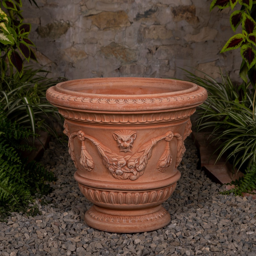

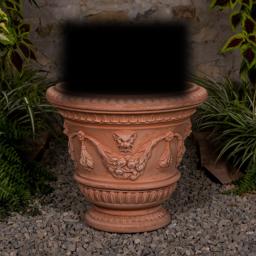

In [40]:
# 1) immagine alla risoluzione del tokenizer (es. 256x256)
image = Image.open(INPUTS_PATH/"real/vase/vaso1.jpg").convert("RGB").resize((256,256), Image.BICUBIC)
img   = image_to_tensor(image, device)                   # [1,3,256,256]

# 2) maschera binaria (1 fuori / 0 dentro)
mask  = generate_mask(img, x0=60, y0=20, w=130, h=80)  # [1,1,256,256]
mask = tvf.gaussian_blur(mask, 31)
# 3) immagine mascherata
masked_img = mask * img

# 4) seed con rumore low-freq SOLO dentro (1-mask)
"""
noise = torch.randn_like(img) * 0.35
noise = torch.nn.functional.avg_pool2d(noise, kernel_size=25, stride=1, padding=12)
seed  = mask * img + (1 - mask) * noise
seed  = seed.clamp(0,1)

# 5) verifica (deve essere >~ 0.05)
print("seed−masked_img (hole) mean abs:",
      ((seed - masked_img).abs() * (1 - mask)).mean().item())
display(tensor_to_image(seed))
"""
display(tensor_to_image(img))
display(tensor_to_image(masked_img))

### TokenResetter
Durante l’ottimizzazione test-time (tto(...)), il modello non genera l’immagine con un forward classico tipo diffusion, ma:


1.   parte da un insieme di token latenti (1D, compressi dal tokenizer TiTok),
2.   li ottimizza iterativamente per minimizzare una loss di obiettivo (es. CLIPObjective, ReconstructionObjective, ecc.),
3. dopo ogni step, decodifica i token per ottenere un’immagine, calcola la loss e aggiorna i token.

Il problema nasce nell’inpainting: se lasci che i token vengano ottimizzati liberamente su tutta l’immagine, anche le zone fuori dalla maschera (cioè quelle che dovrebbero restare identiche all’originale) vengono corrotte nel tempo.
Il TokenResetter serve esattamente a evitare questo

In [12]:
class TokenResetter:
    def __init__(self, titok, masked_img, mask, reset_period=5):
        self.titok = titok
        self.masked_img = masked_img
        self.mask = mask
        self.reset_period = reset_period

    #mask=0 dentro buco e mask=1 fuori buco
    #mask*masked_img resetta
    @torch.no_grad()
    def __call__(self, info):
        if info.i % self.reset_period != 0:
            return
        img = tto.decode(info.tokens).clamp(0., 1.)
        dec_reset = self.mask * self.masked_img + (1 - self.mask) * img
        return self.titok.encoder(dec_reset, self.titok.latent_tokens)

## Callback

In [13]:
class InpaintingPlotter:
    def __init__(self, masked_img, mask):
        self.masked_img = masked_img
        self.mask = mask

    def __call__(self, info):
        if info.i % 50 == 0:
            print(f"i = {info.i}")
            img = tto.decode(info.tokens).clamp(0., 1.)
            img_blended = (1. - self.mask) * img + self.masked_img
            display(tensor_to_image(*img_blended))
            display(tensor_to_image(info.img))
            display(tensor_to_image(img))


In [41]:
prompt="a photo of a garden pot with blue flowers above it"
clip_objective=CLIPObjective(num_augmentations=16, cfg_scale=2.4,prompt=prompt).to(device)
reconstruction_objective=ReconstructionObjective(masked_img,mask)
objective=MultiObjective([clip_objective,reconstruction_objective],[2.0,4.0])

In [42]:
tto.objective=objective

## Loop principale

input


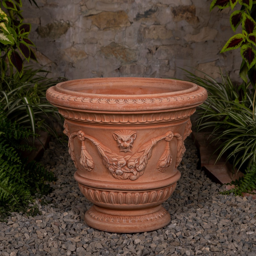

a photo of a garden pot with blue flowers above it
i = 0


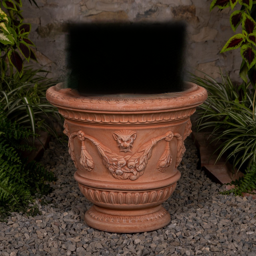

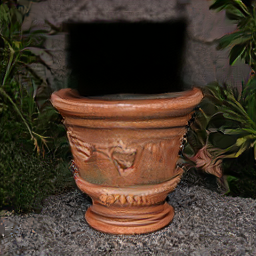

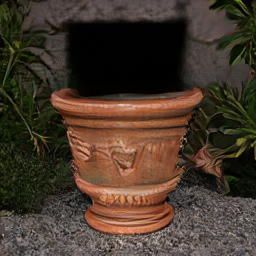

i = 50


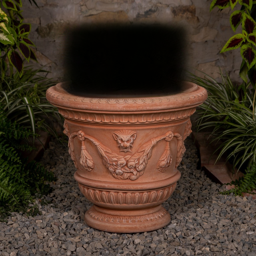

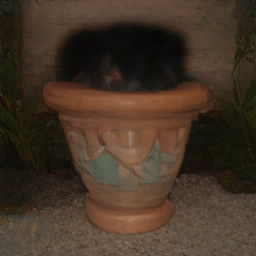

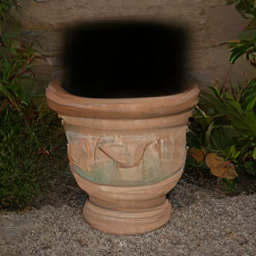

i = 100


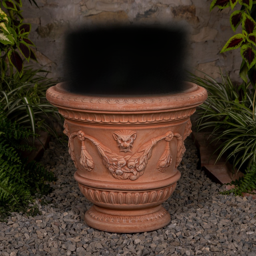

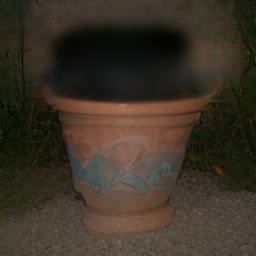

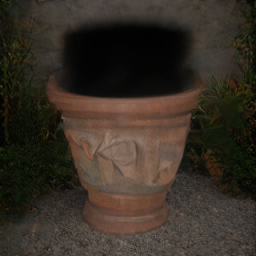

i = 150


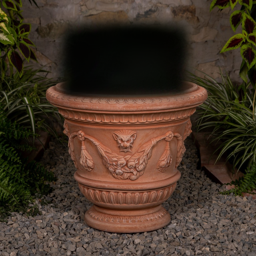

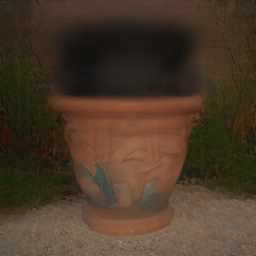

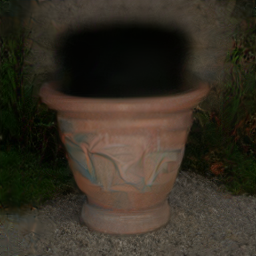

i = 200


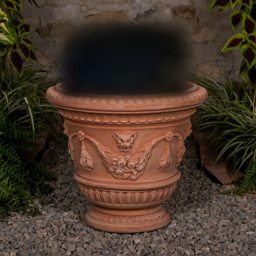

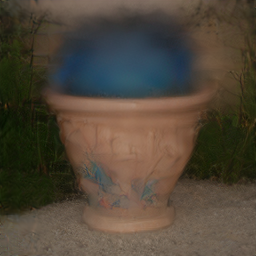

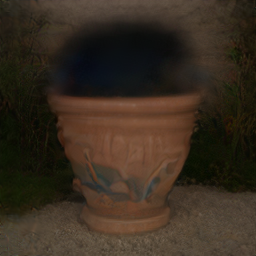

i = 250


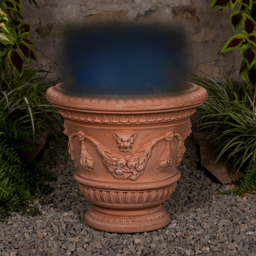

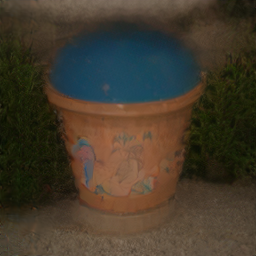

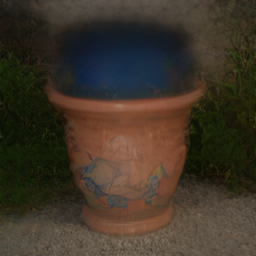

i = 300


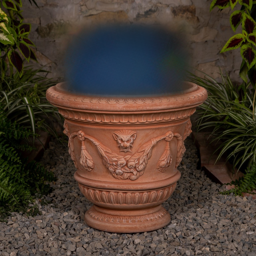

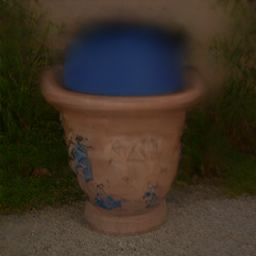

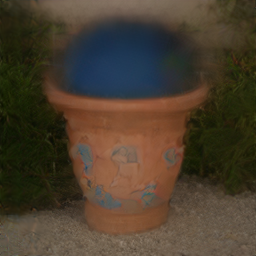

i = 350


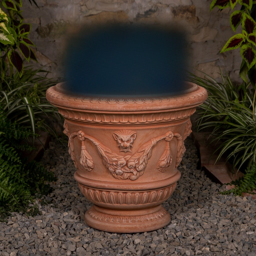

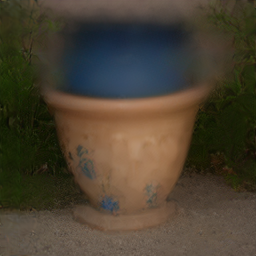

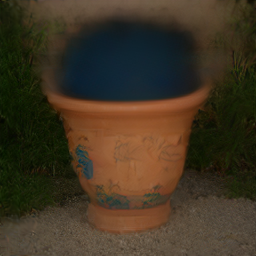

i = 400


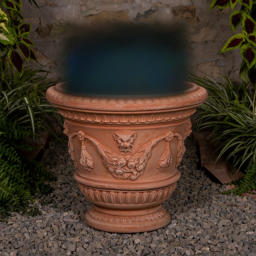

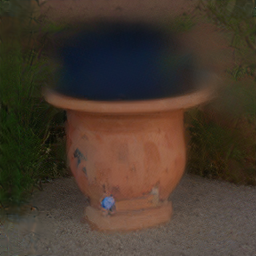

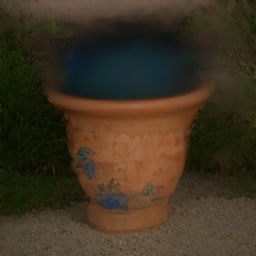

'\nprompt="fill ONLY the masked area with vivid RED poppy flowers and green stems;no grass, no palm leaves; do NOT change the vase or background; realistic, high detail, flowers emerging from the opening"\nobjective.objectives[0].prompt=prompt\ntto.config.num_iter = 200\ntto.config.lr = 2e-2\ntto.config.ema_decay = 0.995\nobjective.weights = [0.0, 8.0]\nimg_mid, _ = tto(seed=masked_img, callback=InpaintingPlotter(masked_img, mask))\n\n# Fase B — genera nel buco\ntto.config.num_iter = 600\ntto.config.lr = 1e-2\ntto.config.ema_decay = 0.999\nobjective.weights = [5.0, 6.0]\nimg_opt, _ = tto(seed=img_mid, callback=InpaintingPlotter(masked_img, mask))\n'

In [43]:
print("input")

display(tensor_to_image(img))


print(tto.objective.objectives[0].prompt)

img_opt,loss = tto(
    seed=masked_img,
    callback=InpaintingPlotter(masked_img, mask),
    )

  #  token_reset_callback=TokenResetter(tto.titok, masked_img, mask)

"""
prompt="fill ONLY the masked area with vivid RED poppy flowers and green stems;no grass, no palm leaves; do NOT change the vase or background; realistic, high detail, flowers emerging from the opening"
objective.objectives[0].prompt=prompt
tto.config.num_iter = 200
tto.config.lr = 2e-2
tto.config.ema_decay = 0.995
objective.weights = [0.0, 8.0]
img_mid, _ = tto(seed=masked_img, callback=InpaintingPlotter(masked_img, mask))

# Fase B — genera nel buco
tto.config.num_iter = 600
tto.config.lr = 1e-2
tto.config.ema_decay = 0.999
objective.weights = [5.0, 6.0]
img_opt, _ = tto(seed=img_mid, callback=InpaintingPlotter(masked_img, mask))
"""


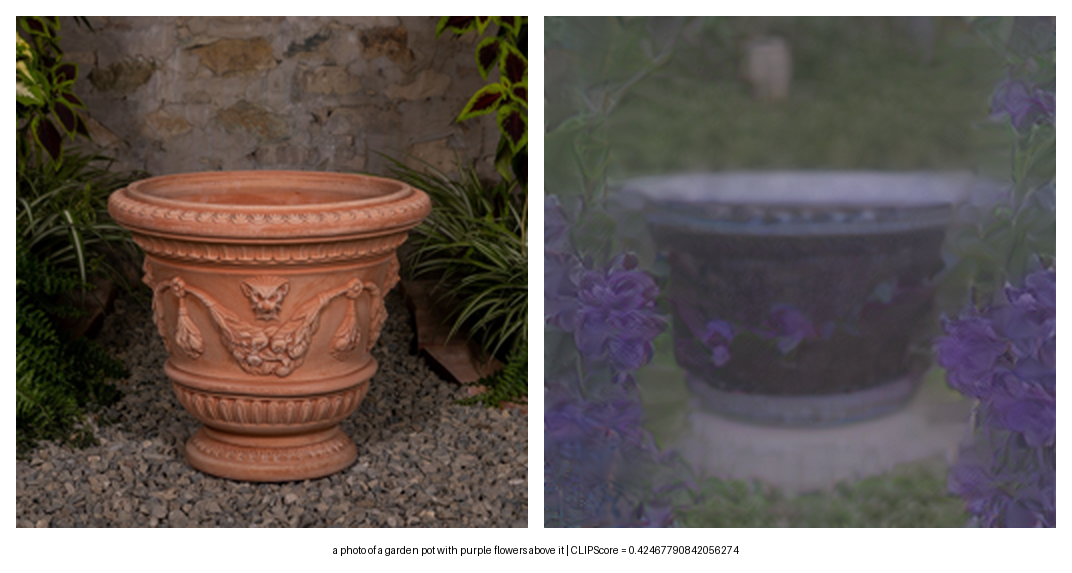

In [56]:
ImageSaver.create_side_by_side_with_caption(
              image,
              tensor_to_image(img_opt),
              prompt=prompt,
              value=(-loss.detach().mean()).item(),
              out_path=OUT_DIR/f"vase.jpg"
          )

In [72]:

import gc, torch, os

for name in ["tto", "objective"]:   # aggiungi qui eventuali altri handler GPU
    if name in globals():
        del globals()[name]

gc.collect()
torch.cuda.empty_cache()
